In [4]:
from dbconn import querydb, querydbtopandas 
import numpy as np
import pandas as pd

In [5]:
esp_exc = pd.read_excel("especialidades_exceptuadas.xlsx").esp_exceptuadas.tolist()

In [6]:
prestaciones_imagenes = pd.read_excel("prestaciones_imagenes.xlsx",index_col=0).prestac_pres_prestacion.tolist()
prestaciones_imagenes = [str(x) for x in prestaciones_imagenes]
prestaciones_imagenes = str(prestaciones_imagenes).strip("[").strip("]")

In [7]:
centros_de_imagenes = str(pd.read_excel("centros_de_imagenes.xlsx",index_col=0).id_pre_prestador.tolist()).strip("[").strip("]")

In [8]:
homologaciones = pd.read_excel("homologaciones.xlsx",dtype=str,index_col=0)

In [9]:
validacion_0 = homologaciones.validacion_0.dropna().tolist()
validacion_1 = homologaciones.validacion_1.dropna().tolist()
validacion_2 = homologaciones.validacion_2.dropna().tolist()
validacion_3 = homologaciones.validacion_3.dropna().tolist()

In [10]:
mayor = "2019-10"
menor = "2019-09"

In [11]:
df = querydbtopandas(f"""select a11.transac  transac,
a11.id_afiliado  id_afi_afiliado,
a11.id_pres_prestacion  id_pres_prestacion,
max(a17.desc_pres_prestacion)  desc_pres_prestacion,
max(a17.prestac_pres_prestacion)  prestac_pres_prestacion,
a11.transac_rela  transac_rela,
a12.id_pre_prestador  id_pre_prestador0,
max(a14.desc_pre_nombre)  desc_pre_nombre0,
Q.deno,
sum(a11.canti)  QTRANSAC
from DBA.ft_cm_transac_remotas a11
join DBA.d_pre_demandante_transac a12
 on (a11.id_pre_prestador_demandante = a12.id_pre_prestador_demandante)
join DBA.d_pre_prestador a14
 on (a12.id_pre_prestador = a14.id_pre_prestador)
join DBA.d_pres_prestacion a17
 on (a11.id_pres_prestacion = a17.id_pres_prestacion)
LEFT JOIN dba.prestad_costo_centros E
    ON a12.id_pre_prestador_demandante = E.prestad and E.baja_fecha is null and e.prepaga = ( select min(PCC1.prepaga) from dba.prestad_costo_centros PCC1 where PCC1.prestad =  e.prestad )   
LEFT JOIN dba.costo_centros Q
    ON E.centro = Q.centro

where (cast(a11.fecha as date) >= date("{menor}") and cast(a11.fecha as date) < date("{mayor}")
 and a11.id_pre_prestador in ({centros_de_imagenes})
 and a11.tran_tipo in ("IP")
 and a11.baja_fecha is null
 and recha in (0)
 and RTRIM(a17.prestac_pres_prestacion) in ({prestaciones_imagenes})
 and a12.id_pre_prestador <> 0)
group by a11.transac,
Q.deno,
a11.id_afiliado,
a11.id_pres_prestacion,

a11.transac_rela,
a12.id_pre_prestador""")

In [12]:
transac_ref = str(df.transac_rela.tolist()).strip("[").strip("]")

df_id = querydbtopandas(f"""select transac_ref, icd as ICD from DBA.ft_cm_transac_remotas
                    where tran_tipo in ("ID")
                    and cast(fecha as date) >= date("{menor}") and cast(fecha as date) < date("{mayor}")
                    and transac_ref in ({transac_ref})""")

df_ip = df[["id_pre_prestador0","desc_pre_nombre0", "prestac_pres_prestacion", "desc_pres_prestacion", "transac_rela", "deno"]]

In [13]:
for i in validacion_0:
    df_id.loc[df_id["ICD"].str.strip() == i, "ICD" ] = 0
    
for i in validacion_1:
    df_id.loc[df_id["ICD"].str.strip() == i, "ICD" ] = 1 
    
for i in validacion_2:
    df_id.loc[df_id["ICD"].str.strip() == i, "ICD" ] = 2
    
for i in validacion_3:
    df_id.loc[df_id["ICD"].str.strip() == i, "ICD" ] = 3

In [14]:
df_id = df_id[df_id["ICD"].isin([0,1,2,3])]

In [15]:
df_ip.deno = df_ip.deno.replace({None:"None"})

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Tratamiento IP

In [16]:
for i in esp_exc:
    df_ip = df_ip[~df_ip["deno"].str.contains(i)]

#elimino todas las prestaciones menos la rmn mamaria
df_ip_rmnmamaria = df_ip[df_ip["desc_pres_prestacion"] == "RMN Mamaria"]

df_ip = df_ip[~df_ip["desc_pres_prestacion"].isin([x for x in df_ip["desc_pres_prestacion"] if 'mam' in x.lower()])]

df_ip = pd.concat([df_ip, df_ip_rmnmamaria],axis=0)

df_id = df_id.groupby("transac_ref")["ICD"].unique().reset_index()

def greatest_selection (df_id):
    for i in range(len(df_id.ICD)):
        if len(df_id.ICD[i]) <= 1:
            df_id.ICD[i] = df_id.ICD[i][0]
            
        elif len(df_id.ICD[i]) > 1:
            df_id.ICD[i].sort()
            df_id.ICD[i] = df_id.ICD[i][-1]
    return df_id

df_id = greatest_selection(df_id)

final = pd.merge(df_ip, df_id, left_on="transac_rela",right_on= "transac_ref")

final = final[["id_pre_prestador0","desc_pre_nombre0", "deno","ICD"]]

q_transacciones= final.groupby(["id_pre_prestador0"]).count().reset_index()[["id_pre_prestador0","desc_pre_nombre0"]].rename(columns={"desc_pre_nombre0": "Q de transacciones"})

final_pivot = pd.pivot_table(final, values='id_pre_prestador0', 
               index=['id_pre_prestador0', 'desc_pre_nombre0', "deno"],
                columns="ICD", aggfunc="size")

final_pivot.fillna(0,inplace=True)
final_pivot.reset_index(inplace=True)
final_pivot = pd.merge(q_transacciones, final_pivot)

final_pivot["Normalidad"] = (final_pivot[0] + final_pivot[1] )/ final_pivot["Q de transacciones"]

total_esp = final_pivot.groupby("deno")["Q de transacciones"].sum().reset_index().rename(columns={"Q de transacciones": "total_esp"})

final_pivot = pd.merge(final_pivot, total_esp)
final_pivot["Participación"] = final_pivot["Q de transacciones"] / final_pivot["total_esp"]
final_pivot["Participación"] = final_pivot["Participación"].mul(100).astype(float).round(2).astype(str).add('%')
final_pivot.rename(columns={"id_pre_prestador0": "N° Prescriptor", "desc_pre_nombre0": "Prescriptor","Q de transacciones": "Total general"},inplace=True)
imagenes_tabla = final_pivot[["N° Prescriptor", "Prescriptor", 0,1,2,3,  "Total general","Normalidad", "Participación" ]]

final_imagenes = imagenes_tabla.sort_values(by= "Total general", ascending= False)

final_imagenes.columns = ['N° Prescriptor', 'Prescriptor', '0', '1', '2', '3', 'Total general',
       'Normalidad', 'Participación']

final_imagenes = final_imagenes.reset_index(drop=True).round(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
final_imagenes

,N° Prescriptor,Prescriptor,0,1,2,3,Total general,Normalidad,Participación
0,164073,"Prueba alterio,Walter",80.0,52.0,154.0,1.0,287,0.46,100.0%
1,145820,"Quesada,Gabriela",61.0,53.0,52.0,0.0,166,0.69,5.63%
2,40237,"Schneider,Javier M.",8.0,7.0,37.0,0.0,52,0.29,13.51%
3,130568,"Caceres,María Valeria",8.0,16.0,28.0,0.0,52,0.46,21.4%
4,193673,"Barcellos,Rosa",32.0,13.0,5.0,0.0,50,0.90,6.93%
...,...,...,...,...,...,...,...,...,...
3134,237151,"Schimpl,Andrea",1.0,0.0,0.0,0.0,1,1.00,0.03%
3135,237168,"Smetniansky,Silvia Ines",0.0,0.0,1.0,0.0,1,0.00,0.03%
3136,237276,"Somoza,Santiago",0.0,0.0,1.0,0.0,1,0.00,0.03%
3137,237343,"Sifon,María del Rosario",0.0,0.0,1.0,0.0,1,0.00,0.03%


RIS

In [21]:
pd.set_option('display.max_columns', 500) 

In [372]:
ris = querydbtopandas("""select * from dba.XHIS_EST_F_RIS
                         where cast(FECHA_AGENDADA as date) >= date("2019-01-01") and cast(FECHA_AGENDADA as date) < date("2019-04-30") """) 

In [373]:
ris.ESTADO.unique()

array(['Exam Done', 'Cancelled', 'Approved', 'Arrived', 'Signed 1',
       'In Progress', 'Pending'], dtype=object)

In [374]:
#PRIMERO SOLO ME QUEDO CON AQUELLOS CON ESTADO APROBADO 
ris = ris[ris["ESTADO"] == 'Approved']

In [375]:
ris["ID_DIAGNO"].unique()

array(['X', '2', ' ', '3', '1', 'E0', 'BR3', 'BR0', 'BR2', 'E1', 'E2',
       'BR1', 'BR4', 'E3', 'BR5', 'BR6'], dtype=object)

In [376]:
#elimino aquellos sin diagnos
for i in ['BR3', 'BR0', 'BR2',  'BR1', 'BR4','BR5', 'BR6', ' ', "X"]:
    ris = ris[ris["ID_DIAGNO"] != i]

In [377]:
ris["ID_DIAGNO"].unique()

array(['2', '3', '1', 'E0', 'E1', 'E2', 'E3'], dtype=object)

In [384]:
ris.HIS_ID = ris.HIS_ID.str.replace("\n", "")
for i in ['H', 'P', 'G']:
    ris.HIS_ID = ris.HIS_ID.str.replace(i, "")

In [386]:
ris = ris[ris["HIS_ID"] != '']

In [387]:
new = ris.HIS_ID.str.split("-", expand= True)

In [388]:
#new.fillna(value= "0", inplace=True)
#new[new == ""] = "0"
HIS_ID = []
for i,j,k in [values for key,values in new.iterrows()]:
    if len(i) > 5:
        HIS_ID.append(i)
    elif len(j) > 5:
        HIS_ID.append(j)
    elif len(k) >5:
        HIS_ID.append(K)

In [389]:
len(HIS_ID)

54226

In [390]:
len(ris)

54226

In [394]:
ris['ID_DIAGNO'].unique()

array(['2', '3', '1', 'E0', 'E1', 'E2', 'E3'], dtype=object)

In [395]:
len(ris)

54226

In [195]:
ris_jose_1 = pd.read_csv("ris_jose.csv",error_bad_lines=False, engine='python', usecols=["ID_PACIENTE",
                                                                           "PACIENTE", "FECHA_NAC", "HIS_ID", "RIS_ID", "AGENDADO", "AFILIADO", "SITIO",
                                                                           "GRUPO", "DIAG.", "TIPO"])

Skipping line 56474: unexpected end of data


In [196]:
len(ris_jose_1)

56472

In [197]:
ris_jose_2 = pd.read_csv("ris_jose_parte2.csv",error_bad_lines=False, engine='python', header=None, usecols= [2,7, 12, 14, 16,21, 22, 26, 29, 32, 34 ], )

In [198]:
ris_jose_2.columns = ["ID_PACIENTE", "PACIENTE", "FECHA_NAC", "HIS_ID", "RIS_ID", "AGENDADO", "AFILIADO", "SITIO",
                                                                           "GRUPO", "DIAG.", "TIPO"]

In [199]:
len(ris_jose_2)

31093

In [201]:
ris_jose = pd.concat([ris_jose_1, ris_jose_2],axis=0)

In [236]:
# en los valores de tu resporte tmb tengo nulos en hid id 
ris_jose = ris_jose[ris_jose["HIS_ID"].notna()]

In [203]:
ris_jose.HIS_ID.unique()

array(['G1623815-01-1', 'P-27007845-1', 'H4488482-1', ..., 'H5535500-1',
       'P-27779712-1', 'P-27779733-1'], dtype=object)

In [204]:
ris_jose.HIS_ID = ris_jose.HIS_ID.str.replace("\n", "")

#ris_jose.HIS_ID = ris_jose.HIS_ID.str.replace("-1", "")

#ris_jose.HIS_ID = ris_jose.HIS_ID.str.replace("-01", "")

for i in ['H', 'P', 'G']:
    ris_jose.HIS_ID = ris_jose.HIS_ID.str.replace(i, "")

#ris_jose.HIS_ID = ris_jose.HIS_ID.str.replace("-", "")

In [237]:
new = ris_jose.HIS_ID.str.split("-", expand= True)

In [226]:
#new.fillna(value= "0", inplace=True)

In [227]:
#new[new== ""] = "0"

In [238]:
HIS_ID = []
for i,j,k in [values for key,values in new.iterrows()]:
    if len(i) > 5:
        HIS_ID.append(i)
    elif len(j) > 5:
        HIS_ID.append(j)
    elif len(k) >5:
        HIS_ID.append(K)

In [241]:
len(HIS_ID)

85833

In [239]:
len(new)

85833

In [240]:
len(ris_jose)

85833

In [242]:
ris_jose["HIS_ID_limpio"] = HIS_ID

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [243]:
ris_jose

,ID_PACIENTE,PACIENTE,FECHA_NAC,HIS_ID,RIS_ID,AGENDADO,AFILIADO,SITIO,GRUPO,DIAG.,TIPO,HIS_ID_limpio
0,VHF279817,"GONZALEZ, CARMEN",18/12/1926,1623815-01-1,5.001551e+09,01/01/19 9:05,8000063002091010050,De Los Arcos,TAC CABEZA,X,H,1623815
1,PDF30449753,"CAMPENNI, NOELIA SOLEDAD",31/08/1983,-27007845-1,5.001551e+09,01/01/19 14:03,8000060746749011042,SBN Ecografia General,ECOGRAFIA GENERAL,E0,U,27007845
2,VHM344313,"RAPAPORTE, IAACOB ISRAEL",20/10/2005,4488482-1,5.001551e+09,01/01/19 12:58,8000060548283051016,De Los Arcos,TAC OSTEOARTICULAR,2,U,4488482
3,PDM24127816,"SUAREZ, GUSTAVO MAXIMILIANO",10/10/1974,-27007722-1,5.001551e+09,01/01/19 12:41,8000060677175011026,SMC Barrio Norte,TAC ABDOMEN,2,U,27007722
4,PDM10424851,"MASCIALINO, PABLO",30/06/1952,-27008739-1,5.001551e+09,01/01/19 21:03,8000060469225010004,SMC Barrio Norte,TAC TORAX,3,U,27008739
...,...,...,...,...,...,...,...,...,...,...,...,...
31082,VHF418267,"SOUR, ELIZABETH VIVIANA",05/06/1965,5535516-1,5.001821e+09,30/04/19 15:56,8000060228936020102,De Los Arcos,TAC COLUMNA,X,C,5535516
31083,VHF24819,"ARANDA, BRENDA ALEXANDRA",27/02/1994,5519787-1,5.001821e+09,30/04/19 15:56,8000063009526040008,CyMSA,ECOGRAFIA MAMARIA,BR3,C,5519787
31084,VHF506058,"MELO HERNANDEZ, PAMELA LORENA",06/12/1979,5535500-1,5.001821e+09,30/04/19 15:57,8000061155578010001,CyMSA,ECOGRAFIA MAMARIA,BR2,C,5535500
31085,PDM10479401,"TOMASELLO BARCIA, CARLOS DANTE",15/12/1952,-27779712-1,5.001821e+09,30/04/19 15:57,8000060228181021078,SBP Ecografia General,ECOGRAFIA DOPPLER,E1,A,27779712


In [245]:
import seaborn as sns

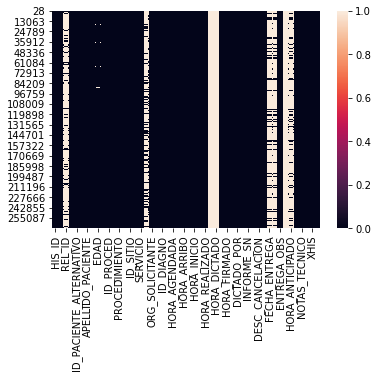

In [396]:
sns.heatmap(ris.isna())

In [249]:
ris_jose.HIS_ID_limpio.value_counts()

4793235     6
4662005     5
1694098     4
5486042     4
4820851     4
           ..
5042329     1
5183875     1
27176992    1
4510077     1
27138092    1
Name: HIS_ID_limpio, Length: 84830, dtype: int64

In [251]:
ris_jose[ris_jose["HIS_ID_limpio"] == "4793235"]

,ID_PACIENTE,PACIENTE,FECHA_NAC,HIS_ID,RIS_ID,AGENDADO,AFILIADO,SITIO,GRUPO,DIAG.,TIPO,HIS_ID_limpio
34150,VHM368913,"ARAUJO GARCIA, GUSTAVO ADOLFO",22/09/1982,4793235-1,5.001642e+09,13/02/19 11:11,8000061129712010003,CyMSA,RX ART.PEQUE,X,C,4793235
34151,VHM368913,"ARAUJO GARCIA, GUSTAVO ADOLFO",22/09/1982,4793235-3,5.001642e+09,13/02/19 11:11,8000061129712010003,CyMSA,RX ART.PEQUE,X,C,4793235
34421,VHM368913,"ARAUJO GARCIA, GUSTAVO ADOLFO",22/09/1982,4793235-5,5.001642e+09,13/02/19 11:11,8000061129712010003,CyMSA,RX ART.PEQUE,X,C,4793235
34562,VHM368913,"ARAUJO GARCIA, GUSTAVO ADOLFO",22/09/1982,4793235-2,5.001642e+09,13/02/19 11:11,8000061129712010003,CyMSA,RX ART.PEQUE,X,C,4793235
34563,VHM368913,"ARAUJO GARCIA, GUSTAVO ADOLFO",22/09/1982,4793235-4,5.001642e+09,13/02/19 11:11,8000061129712010003,CyMSA,RX ART.PEQUE,X,C,4793235
34564,VHM368913,"ARAUJO GARCIA, GUSTAVO ADOLFO",22/09/1982,4793235-6,5.001642e+09,13/02/19 11:11,8000061129712010003,CyMSA,RX ART.PEQUE,X,C,4793235


In [255]:
ris_jose_correcto = ris_jose[["ID_PACIENTE", "PACIENTE","HIS_ID_limpio", "DIAG." ]].drop_duplicates()   #85833 

In [259]:
merged = pd.merge(ris_jose_correcto, ris_correcto, left_on = "HIS_ID_limpio" , right_on= "HIS_ID_limpio")

In [260]:
merged

,ID_PACIENTE,PACIENTE,HIS_ID_limpio,DIAG.,ID_PACIENTE_PRINCIPAL,NOMBRE_PACIENTE,APELLIDO_PACIENTE,ID_DIAGNO
0,VHF279817,"GONZALEZ, CARMEN",1623815,X,VHF279817,CARMEN,GONZALEZ,X
1,PDF30449753,"CAMPENNI, NOELIA SOLEDAD",27007845,E0,PDF30449753,NOELIA SOLEDAD,CAMPENNI,E0
2,VHM344313,"RAPAPORTE, IAACOB ISRAEL",4488482,2,VHM344313,IAACOB ISRAEL,RAPAPORTE,2
3,PDM24127816,"SUAREZ, GUSTAVO MAXIMILIANO",27007722,2,PDM24127816,GUSTAVO MAXIMILIANO,SUAREZ,2
4,PDM10424851,"MASCIALINO, PABLO",27008739,3,PDM10424851,PABLO,MASCIALINO,3
...,...,...,...,...,...,...,...,...
76326,VHF173851,"HOCHSTEIN SAUL, RINAT",5477656,BR1,VHF173851,RINAT,HOCHSTEIN SAUL,BR1
76327,PWM991587851,"DESIDERIS VERON, CHRISTIAN MATIAS",27776067,1,PWM991587851,CHRISTIAN MATIAS,DESIDERIS VERON,1
76328,PDF39869123,"ETCHEVERRY, MARTINA ADELA",27776073,1,PDF39869123,MARTINA ADELA,ETCHEVERRY,1
76329,PDF56810274,"NAVARRO COSTA, VICTORIA ANA",27776076,X,PDF56810274,VICTORIA ANA,NAVARRO COSTA,X


In [263]:
(merged["DIAG."]  == merged ["ID_DIAGNO"]).all()

False

In [137]:
(merged["RIS_ID_x"] == merged["RIS_ID_y"]).all()

True

In [264]:
len(merged)

76331

In [267]:
unicas_ris = ris_correcto[~ris_correcto["HIS_ID_limpio"].isin(merged.HIS_ID_limpio)]

In [268]:
len(unicas_ris)

7735

In [269]:
unicas_ris_jose = ris_jose_correcto[~ris_jose_correcto["HIS_ID_limpio"].isin(merged.HIS_ID_limpio)]

In [270]:
len(unicas_ris_jose)

8991

In [271]:
unicas_ris_jose

,ID_PACIENTE,PACIENTE,HIS_ID_limpio,DIAG.
9,VHF340405,"MATA, MARIA ESTER LILIANA",4488767,0
18,PDF33023587,"SUELDO, AGUSTINA MAGALI",27007859,0
37,PDF35016779,"BUCU, SAMANTHA",27008065,0
41,PDM30519623,"ARBIO, FEDERICO MANUEL",27008328,0
52,PDM95483326,"DOS SANTOS, ALAN DAVID",27008830,0
...,...,...,...,...
31082,VHF418267,"SOUR, ELIZABETH VIVIANA",5535516,X
31083,VHF24819,"ARANDA, BRENDA ALEXANDRA",5519787,BR3
31084,VHF506058,"MELO HERNANDEZ, PAMELA LORENA",5535500,BR2
31085,PDM10479401,"TOMASELLO BARCIA, CARLOS DANTE",27779712,E1


In [272]:
unicas_ris

,ID_PACIENTE_PRINCIPAL,NOMBRE_PACIENTE,APELLIDO_PACIENTE,HIS_ID_limpio,ID_DIAGNO
11,PCF12198451,ITALIA,D ALESSANDRO,27523377,2
38,PCF2421645,MARTHA J GALANTE DE,ESSES,27555738,1
61,PCF3046830,JULIA H,BIAIN,27587014,2
62,PCF3056417,DORA DE AUGERI,EVANGELISTA,27545625,X
63,PCF3073201,SARA,PARDO CAMPOS,27545709,X
...,...,...,...,...,...
96771,VHM93381,JUAN MANUEL,COBO,4999711,X
96815,VHM9616,OSCAR ANIBAL,VAZQUEZ,5018419,X
96861,VHM98819,TOMAS ALEJANDRO,ROCHE,5059991,X
96868,VHM99008,ROBERTO JAVIER,CARROZO,5029012,2


In [397]:
#-- GUARDIA CMA - ESTADISTICA PRESCRIPTORES DIAGNOSTICOS IMAGENES
cau = querydbtopandas("""select
    c.consulta_id, 
    ct.fecha_desde, 
    tipo_matricula_med, 
    nro_matricula_med, 
    nom_ape_med_presc, 
    registro_usuario, 
    prest.prestac, 
    prest.exten_deno, 
    es_guardia
from  dba.CMA_CONSULTA_TURNO ct
    join dba.CMA_CONSULTA c
        on c.consulta_id = ct.consulta_id
    join dba.CMA_ETAPA et
        on c.consulta_id = et.consulta_id
    join dba.CMA_CONSULTORIO cons
        on cons.consultorio_id = ct.consultorio_id
    join dba.cma_prestacion_consulta pc
        on c.consulta_id = pc.consulta_id
    join dba.prestaciones prest
        on prest.prestac = pc.prestac
   where  prest.nomen = 29
      and fecha_desde >= '2019/01'
      and fecha_hasta < '2019/04'
      and et.workflow = 1
      and es_guardia = 1
      and nro_matricula_med <> null
      and nro_matricula_med <> ' '
      and et.etapa_id = (select min(etapa_id) from dba.cma_etapa eta where et.consulta_id = eta.consulta_id and eta.workflow = 1)""")

In [398]:
cau

,consulta_id,fecha_desde,tipo_matricula_med,nro_matricula_med,nom_ape_med_presc,registro_usuario,prestac,exten_deno,es_guardia
0,27005902.0,2019-01-02 07:13:00,MN,94870,DR. CAPPARELLI GERMÁN E. ...,"uid=elderosa,cn=Elizabeth De Rosa,ou5=Swiss Me...",RA03001,TORAX CON O SIN RELLENO ESOFAGO,True
1,27005907.0,2019-01-02 07:16:00,MN,94870,DR. CAPPARELLI GERMÁN E. ...,"uid=elderosa,cn=Elizabeth De Rosa,ou5=Swiss Me...",RA03001,TORAX CON O SIN RELLENO ESOFAGO,True
2,27005908.0,2019-01-02 07:18:00,MN,94870,DR. CAPPARELLI GERMÁN E. ...,"uid=elderosa,cn=Elizabeth De Rosa,ou5=Swiss Me...",RA03001,TORAX CON O SIN RELLENO ESOFAGO,True
3,27005918.0,2019-01-02 07:22:00,MN,94870,DR. CAPPARELLI GERMÁN E. ...,"uid=elderosa,cn=Elizabeth De Rosa,ou5=Swiss Me...",RA03001,TORAX CON O SIN RELLENO ESOFAGO,True
4,27005923.0,2019-01-02 07:24:00,MN,94870,DR. CAPPARELLI GERMÁN E. ...,"uid=elderosa,cn=Elizabeth De Rosa,ou5=Swiss Me...",RA03001,TORAX CON O SIN RELLENO ESOFAGO,True
...,...,...,...,...,...,...,...,...,...
45133,27630944.0,2019-03-31 23:39:00,MN,150264,RODRIGO M ISABELLI ...,"uid=cma_diegoa,cn=Diego Amanatto,ou4=C. Med. A...",RA02010,RAQUIS EXPOSICION SUBSIGUIENTE,True
45134,27630945.0,2019-03-31 23:44:00,MN,131309,BELISARIO BUITRAGO ...,"uid=igpeluso,cn=Ignacio Peluso,ou5=Swiss Medic...",TC10001,TC DE CEREBRO,True
45135,27631189.0,2019-03-30 14:31:00,MN,123926,DEBORA G IARIA ...,"uid=cabengoa,cn=Carolina Bengoa,ou5=Swiss Medi...",EC01046,ECODOPPLER TESTICULAR,True
45136,27632048.0,2019-03-25 10:00:00,MN,25702,DR ROMANELLI JORGE ...,"uid=cym_valeriasac,cn=Valeria Sack,ou5=G. Gene...",RA02013,"CODO, ANTEBRAZO, MUÑECA, MANO, DEDOS, RODILLA,...",True


In [405]:
cau["consulta_id"] = cau["consulta_id"].astype(str).str[:-2]

In [407]:
pd.merge(ris, cau, left_on="HIS_ID_limpio", right_on="consulta_id")[["HIS_ID_limpio", "consulta_id"]]

,HIS_ID_limpio,consulta_id
0,27007580,27007580
1,27007580,27007580
2,27007658,27007658
3,27007722,27007722
4,27007769,27007769
...,...,...
5196,27630846,27630846
5197,27630846,27630846
5198,27630854,27630854
5199,27630894,27630894


In [408]:
len(ris)

54226

In [409]:
len(cau)

45138

In [208]:
#cau.consulta_id.unique().tolist() 

In [89]:
cau.consulta_id#   (ris.HIS_ID)

0      23920743.0
1      23920932.0
2      23920945.0
3      23921053.0
4      23921067.0
          ...    
995    23940984.0
996    23940989.0
997    23941005.0
998    23941005.0
999    23941009.0
Name: consulta_id, Length: 1000, dtype: float64

In [219]:
ris.loc[ris['HIS_ID'] == "", 'HIS_ID'] = np.nan
#ris.HIS_ID[ris.HIS_ID == "", ris.HIS_ID] = np.nan

In [220]:
ris['HIS_ID'].dropna()

0           1623710
1          27007358
2          27007359
3          27007360
4          27007361
            ...    
196681      5176903
196682      5176898
196683     51768982
196684    173223504
196685      5174551
Name: HIS_ID, Length: 195222, dtype: object

In [173]:
set(ris.HIS_ID.dropna().astype(int)) in set(cau.consulta_id)

False

In [126]:
ris.HIS_ID[ris.HIS_ID.astype(str).str[:2] == "23"]

603001    2302075
603005    2302076
603009    2302096
603015    2302110
603016    2302116
           ...   
901122    2302022
901138    2302034
901141    2302037
901146    2302043
901151    2302048
Name: HIS_ID, Length: 522, dtype: object

In [104]:
for i in ris.HIS_ID:
    if len(i) == 0:
        i = np.nan

In [205]:
#ris.HIS_ID.tolist()

In [279]:
#- PROGRAMADA CMA - ESTADISTICA PRESCRIPTORES DIAGNOSTICOS IMAGENES
cau1 = querydbtopandas("""select 
    c.consulta_id, 
    ct.fecha_desde, 
    tipo_matricula_med, 
    nro_matricula_med, 
    nom_ape_med_presc, 
    registro_usuario, 
    prest.prestac, 
    prest.exten_deno, 
    es_guardia
from  dba.CMA_CONSULTA_TURNO ct
    join dba.CMA_CONSULTA c
        on c.consulta_id = ct.consulta_id
    join dba.CMA_ETAPA et
        on c.consulta_id = et.consulta_id
    join dba.CMA_CONSULTORIO cons
        on cons.consultorio_id = ct.consultorio_id
    join dba.cma_prestacion_consulta pc
        on c.consulta_id = pc.consulta_id
    join dba.prestaciones prest
        on prest.prestac = pc.prestac
   where  prest.nomen = 29
      and fecha_desde >= '2019/01'
      and fecha_hasta < '2019/02'
      and et.workflow = 2""")

In [280]:
len(cau1)

283783

In [431]:
#cau armado por mi
# programada 
cau2 = querydbtopandas("""select 
c.consulta_id, 
ct.fecha_desde, 
tipo_matricula_med, 
nro_matricula_med, 
nom_ape_med_presc, 
registro_usuario, 
prest.prestac, 
prest.exten_deno, 
es_guardia
 from  dba.cma_consulta_turno ct, dba.cma_consulta c, dba.CMA_ETAPA et, dba.cma_consultorio cons, dba.cma_prestacion_consulta pc, dba.prestaciones prest
where c.consulta_id = ct.consulta_id
and c.consulta_id = et.consulta_id
and cons.consultorio_id = ct.consultorio_id
and c.consulta_id = pc.consulta_id
and prest.prestac = pc.prestac
and prest.nomen = 29
and fecha_desde >= '2019-01'
and fecha_hasta < '2019-05'
and et.workflow = 2
and es_guardia = 0
and nro_matricula_med <> null
and nro_matricula_med <> ' '
and et.etapa_id = (select min(etapa_id) from dba.CMA_ETAPA eta where et.consulta_id = eta.consulta_id and eta.workflow = 2)""")

In [432]:
len(cau2)

111894

In [433]:
cau2.columns

Index(['consulta_id', 'fecha_desde', 'tipo_matricula_med', 'nro_matricula_med',
       'nom_ape_med_presc', 'registro_usuario', 'prestac', 'exten_deno',
       'es_guardia'],
      dtype='object')

In [434]:
cau2["consulta_id"]

0         26399533.0
1         26399533.0
2         26411885.0
3         26411885.0
4         26425946.0
             ...    
111889    27792454.0
111890    27792468.0
111891    27817074.0
111892    27818698.0
111893    28188452.0
Name: consulta_id, Length: 111894, dtype: float64

In [445]:
cau2["consulta_id"] = cau2["consulta_id"].astype(str)[:-2]

In [449]:
cau2["consulta_id"] = cau2["consulta_id"].str[:-2]

In [454]:
cau2 = cau2[cau2["consulta_id"].notna()]

In [456]:
final = pd.merge(ris, cau2, left_on= "HIS_ID_limpio", right_on="consulta_id")

In [458]:
final.columns

Index(['HIS_ID', 'RIS_ID', 'REL_ID', 'ID_PACIENTE_PRINCIPAL',
       'ID_PACIENTE_ALTERNATIVO', 'NOMBRE_PACIENTE', 'APELLIDO_PACIENTE',
       'SEXO_PACIENTE', 'EDAD', 'FECHA_NACIMIENTO', 'ID_PROCED',
       'GRUPO_ESTUDIO', 'PROCEDIMIENTO', 'ORIGEN', 'ID_SITIO', 'ID_EQUIPO',
       'SERVICIO', 'CODIGO_FINANCIADOR', 'ORG_SOLICITANTE', 'ESCANEO',
       'ID_DIAGNO', 'FECHA_AGENDADA', 'HORA_AGENDADA', 'FECHA_ARRIBO',
       'HORA_ARRIBO', 'FECHA_INICIO', 'HORA_INICIO', 'FECHA_REALIZADO',
       'HORA_REALIZADO', 'FECHA_DICTADO', 'HORA_DICTADO', 'FECHA_FIRMADO',
       'HORA_FIRMADO', 'REALIZADO_POR', 'DICTADO_POR', 'FIRMADO_POR',
       'INFORME_SN', 'ESTADO', 'DESC_CANCELACION', 'ENTREGA', 'FECHA_ENTREGA',
       'HORA_ENTREGA', 'ENTREGA_OBS', 'FECHA_ANTICIPADO', 'HORA_ANTICIPADO',
       'ULTIMA_ACTUALIZACION', 'NOTAS_TECNICO', 'COD_CENTRO', 'XHIS',
       'HIS_ID_limpio', 'consulta_id', 'fecha_desde', 'tipo_matricula_med',
       'nro_matricula_med', 'nom_ape_med_presc', 'registro_usu

In [521]:
final.nro_matricula_med = final.nro_matricula_med.str.strip()

In [ ]:
matriculas = final.nro_matricula_med.str.strip().unique()

In [503]:
matriculas_st = str(matriculas.tolist()).lstrip("[").rstrip("]")

In [567]:
len(matriculas_st)

43589

In [531]:
prestadores = querydbtopandas(f"""select
a14.desc_pre_nombre,
trim(a14.pre_matricula_nac) matricula,
a14.id_pre_prestador,
Q.deno
from DBA.d_pre_prestador a14
LEFT JOIN dba.prestad_costo_centros E
    ON a14.id_pre_prestador = E.prestad and E.baja_fecha is null and e.prepaga = ( select min(PCC1.prepaga) from dba.prestad_costo_centros PCC1 where PCC1.prestad =  e.prestad )   
LEFT JOIN dba.costo_centros Q
    ON E.centro = Q.centro
where trim(pre_matricula_nac)  in ({matriculas_st})""")

In [568]:
prestadores

,desc_pre_nombre,matricula,id_pre_prestador,deno
0,"Aleman,Lisardo",31715,20675,Ginecología
1,"Nassif,Juan C.",41566,21887,Obstetricia - Médicos
2,"Quadrelli,Silvia A.",59124,22310,Neumonología
3,"Castellaro,Carlos E.",76439,24331,Clínica Médica
4,"Grinstein,Karina A.",103072,91203,Pediatría
...,...,...,...,...
5053,"RODRIGUEZ, ALEJANDRA",105420,517444,None
5054,"MOLINARI, MARIO",110966,503286,None
5055,"SILVA, DAMIAN",111756,503846,None
5056,"NEME, MARIO GABRIEL",11942,506035,None


In [566]:
len(prestadores)

5058

In [533]:
prestadores["matricula"].values

array(['31715', '41566', '59124', ..., '111756', '11942', '12159'],
      dtype=object)

In [569]:
imagenes = pd.merge(final[["nro_matricula_med", "ID_DIAGNO"]], prestadores, left_on = "nro_matricula_med", right_on = "matricula", how = "inner") 

In [572]:
imagenes.ID_DIAGNO.unique()

array([2, 1, 3, 0], dtype=object)

In [571]:
for i in validacion_0:
    imagenes.loc[imagenes["ID_DIAGNO"].str.strip() == i, "ID_DIAGNO" ] = 0
    
for i in validacion_1:
    imagenes.loc[imagenes["ID_DIAGNO"].str.strip() == i, "ID_DIAGNO" ] = 1 
    
for i in validacion_2:
    imagenes.loc[imagenes["ID_DIAGNO"].str.strip() == i, "ID_DIAGNO" ] = 2
    
for i in validacion_3:
    imagenes.loc[imagenes["ID_DIAGNO"].str.strip() == i, "ID_DIAGNO" ] = 3

AttributeError: Can only use .str accessor with string values!

In [573]:
q_transacciones = imagenes.groupby(["id_pre_prestador", "desc_pre_nombre"])["nro_matricula_med"].count()

In [574]:
q_transacciones

id_pre_prestador  desc_pre_nombre             
0                 Sin Asignar                     13
79                Pelli,Maria J.                   1
155               Suvá,Julio A.                   10
156               Carrere,Carlos A.                4
172               Pasqualini,Rodolfo S.            2
                                                  ..
678104            RAVERA, KARINA A.                2
680335            MASQUEF, CARLOS A.              35
680540            BURASTERO, SANTIAGO EZEQUIEL     1
680612            GONZALEZ, VIRGINIA M            15
682784            FERREIRA, MARIANA A.             1
Name: nro_matricula_med, Length: 5058, dtype: int64

In [605]:
pivot = pd.pivot_table(imagenes, values='nro_matricula_med', 
               index=[ "id_pre_prestador", 'desc_pre_nombre', "deno"],
                columns="ID_DIAGNO", aggfunc="size")

In [606]:
pivot = pivot.fillna(0)

In [607]:
pivot["total"] = pivot[0] + pivot[1] + pivot[2] + pivot[3]

In [608]:
pivot["noramales"] = (pivot[0] + pivot[1]) / pivot["total"]

In [612]:
pivot = pivot.round(2).reset_index()

In [613]:
pivot.columns = ["prestador", "Razón Social", "Especialidad", "0", "1", "2", "3", "total", "% normalidad"]

In [618]:
pivot[pivot["prestador"] == "155"]

,prestador,Razón Social,Especialidad,0,1,2,3,total,% normalidad
570,155,"Suvá,Julio A.",Clínica Médica,0.0,4.0,6.0,0.0,10.0,0.4


In [620]:
pivot.to_excel("ris_cau.xlsx")